In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot


from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

import optuna
import xgboost as xgb
import catboost
from catboost import CatBoostRegressor

import warnings
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


In [2]:
train_wOrdinal = pd.read_csv('~/Documents/AmesHousingML/clean_data_ordinal.csv') 
train_originalCleaned = pd.read_csv('~/Documents/AmesHousingML/clean_data_original.csv') 
train_wOnlyDummies = pd.read_csv('~/Documents/AmesHousingML/clean_data_dummified.csv') 
train_wOnlyDummiesNoDrop = pd.read_csv('~/Documents/AmesHousingML/clean_data_dummified_noDrop.csv') 

In [3]:
print(train_originalCleaned.shape)
print(train_wOnlyDummies.shape)
print(train_wOrdinal.shape)
print(train_wOnlyDummiesNoDrop.shape)

train_wOrdinal = train_wOrdinal.drop('PID', axis=1)
train_originalCleaned = train_originalCleaned.drop('PID', axis=1)
train_wOnlyDummies = train_wOnlyDummies.drop('PID', axis=1)
train_wOnlyDummiesNoDrop = train_wOnlyDummiesNoDrop.drop('PID', axis=1)


(2576, 86)
(2576, 266)
(2576, 86)
(2576, 307)


## Finding & Dealing with Outliers

In [4]:
outlier_threshold = 3

In [5]:
Q1 = train_wOrdinal['SalePrice'].quantile(.25)
Q3 = train_wOrdinal['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + outlier_threshold * IQR
train_wOrdinal.drop(train_wOrdinal[train_wOrdinal['SalePrice'] > new_bounds].index, axis=0, inplace = True)

In [6]:
before_outlier_total = train_wOrdinal.count()[1]
train_wOrdinal.drop(train_wOrdinal[train_wOrdinal['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train_wOrdinal.count()[1]

In [7]:
before_outlier_total - post_outlier_total

23

In [8]:
Q1 = train_originalCleaned['SalePrice'].quantile(.25)
Q3 = train_originalCleaned['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + outlier_threshold * IQR

In [9]:
before_outlier_total = train_originalCleaned.count()[1]
train_originalCleaned.drop(train_originalCleaned[train_originalCleaned['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train_originalCleaned.count()[1]

In [10]:
before_outlier_total - post_outlier_total

23

In [11]:
Q1 = train_wOnlyDummies['SalePrice'].quantile(.25)
Q3 = train_wOnlyDummies['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + outlier_threshold * IQR

In [12]:
before_outlier_total = train_wOnlyDummies.count()[1]
train_wOnlyDummies.drop(train_wOnlyDummies[train_wOnlyDummies['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train_wOnlyDummies.count()[1]

In [13]:
before_outlier_total - post_outlier_total

23

In [14]:
Q1 = train_wOnlyDummiesNoDrop['SalePrice'].quantile(.25)
Q3 = train_wOnlyDummiesNoDrop['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + outlier_threshold * IQR

In [15]:
before_outlier_total = train_wOnlyDummiesNoDrop.count()[1]
train_wOnlyDummiesNoDrop.drop(train_wOnlyDummiesNoDrop[train_wOnlyDummiesNoDrop['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train_wOnlyDummiesNoDrop.count()[1]

In [16]:
before_outlier_total - post_outlier_total

23

In [17]:
masterScores = pd.DataFrame(columns = ['Model', 'r2_5kf_mean', 'rmse_5kf_mean'])

In [18]:
ourFrames = [train_wOrdinal, train_wOnlyDummies, train_wOnlyDummiesNoDrop]   #, train_originalCleaned]

In [19]:
for frame in ourFrames:
    #the features will be X (independent variables)
    X = frame.drop('SalePrice', axis=1)
    X_array = X.values
    #the target (dependent variable) will be y
    y = frame['SalePrice']
    y_array = y.values

    #Split your training and testing sets of data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'RMSE',  # Use appropriate loss function for your task
    'random_seed': 42
                        }

    cat_model = CatBoostRegressor(**params)

    # Train the model on the training set
    cat_model.fit(X_train, y_train)

    # Make predictions on the test set
    cat_model_y_pred = cat_model.predict(X_test)

    # Evaluate the Random Forest model
    cat_model_r2 = r2_score(y_test, cat_model_y_pred)
    print(f'R-squared on the test set: {cat_model_r2}')

    cat_model_mse = mean_squared_error(y_test, cat_model_y_pred)
    print(f'Mean Squared Error on the test set: {cat_model_mse}')

    # Root Mean Squared Error (RMSE) on the test set
    cat_model_rmse = mean_squared_error(y_test, cat_model_y_pred, squared=False)
    print("Root Mean Squared Error (RMSE) on the test set:", cat_model_rmse)

    # Display feature importances
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': cat_model.feature_importances_})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    print('\nFeature Importances:')
    print(feature_importances)
    
    
    # Create a KFold object
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_scores = cross_val_score(cat_model, X, y, cv=kf, scoring='r2')
    # You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

    # Display the cross-validation scores
    print("Cross-Validation Scores:", cv_scores, '\n')

    # Print the mean and standard deviation of the scores
    print(f"Mean R^2: {cv_scores.mean()}", '\n')
    print(f"Standard Deviation R^2: {cv_scores.std()}")
    
        
    print('\n')
    print('\n')
    print('\n')
    
    # feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
    # feat_importances.nlargest(20).plot(kind='barh')

0:	learn: 61768.5516119	total: 57.5ms	remaining: 5.69s
1:	learn: 57665.6124876	total: 59.4ms	remaining: 2.91s
2:	learn: 54157.9846825	total: 60.9ms	remaining: 1.97s
3:	learn: 50575.1373381	total: 62.6ms	remaining: 1.5s
4:	learn: 47562.1182462	total: 64.1ms	remaining: 1.22s
5:	learn: 44628.9366488	total: 65.5ms	remaining: 1.03s
6:	learn: 42069.2583409	total: 67.1ms	remaining: 891ms
7:	learn: 39654.6553343	total: 68.6ms	remaining: 789ms
8:	learn: 37579.6071721	total: 70ms	remaining: 708ms
9:	learn: 35716.5244647	total: 71.4ms	remaining: 643ms
10:	learn: 34137.1101658	total: 73ms	remaining: 591ms
11:	learn: 32617.5469968	total: 74.4ms	remaining: 546ms
12:	learn: 31292.5709904	total: 76ms	remaining: 508ms
13:	learn: 30063.0325520	total: 77.6ms	remaining: 476ms
14:	learn: 28849.5406711	total: 79.1ms	remaining: 448ms
15:	learn: 27868.5587294	total: 80.6ms	remaining: 423ms
16:	learn: 27097.5507627	total: 82.1ms	remaining: 401ms
17:	learn: 26279.9063750	total: 83.7ms	remaining: 381ms
18:	learn

In [20]:
train_wOrdinal.head()

GrLivArea  SalePrice  MSSubClass  MSZoning  LotFrontage  LotArea  Street  \
0        856     126000          30         5         60.0     7890       1   
1       1049     139500         120         5         42.0     4235       1   
2       1001     124900          30         1         60.0     6060       1   
3       1039     114000          70         5         80.0     8146       1   
4       1665     227000          60         5         70.0     8400       1   

   Alley  LotShape  LandContour  Utilities  LotConfig  LandSlope  \
0      1         3            3          0          0          0   
1      1         3            3          0          4          0   
2      1         3            3          0          4          0   
3      1         3            3          0          0          0   
4      1         3            3          0          4          0   

   Neighborhood  Condition1  Condition2  BldgType  HouseStyle  OverallQual  \
0            19           2           2         0           2            6   
1             7           2           2         4           2            5   
2            10           2           2         0           2            5   
3            18           2           2         0           5            4   
4            15           2           2         0           5            8   

   OverallCond  YearBuilt  YearRemodAdd  RoofStyle  RoofMatl  Exterior1st  \
0            6       1939          1950          1         0           13   
1            5       1984          1984          1         0            6   
2            9       1930          2007          3         0            8   
3            8       1900          2003          1         0            8   
4            6       2001          2001          1         0           12   

   Exterior2nd  MasVnrType  MasVnrArea  ExterQual  ExterCond  Foundation  \
0           14           2         0.0          3          3           1   
1            6           1       149.0          4          3           1   
2            8           2         0.0          4          3           0   
3            8           2         0.0          4          4           0   
4           13           2         0.0          4          3           2   

   BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  \
0         4         4             2             3       238.0             1   
1         5         4             3             3       552.0             2   
2         4         4             2             2       737.0             1   
3         3         4             2             1         0.0             1   
4         5         4             2             3       643.0             1   

   BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  Heating  HeatingQC  CentralAir  \
0         0.0      618.0        856.0        1          3           1   
1       393.0      104.0       1049.0        1          3           1   
2         0.0      100.0        837.0        1          5           1   
3         0.0      405.0        405.0        1          4           1   
4         0.0      167.0        810.0        1          5           1   

   Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  BsmtFullBath  BsmtHalfBath  \
0           3       856         0             0           1.0           0.0   
1           3      1049         0             0           1.0           0.0   
2           3      1001         0             0           0.0           0.0   
3           3       717       322             0           0.0           0.0   
4           3       810       855             0           1.0           0.0   

   FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  TotRmsAbvGrd  \
0         1         0             2             1            3             4   
1         2         0             2             1            4             5   
2         1         0             2             1            4             5   
3         1         0

In [21]:
#name the model for our scores tracker
model_name = 'catboost'
#train_wOrdinal = train_wOrdinal.drop('PID', axis=1)
    #the features will be X (independent variables)
X = train_wOrdinal.drop('SalePrice', axis=1)
X_array = X.values
#the target (dependent variable) will be y
y = train_wOrdinal['SalePrice']
y_array = y.values

#Split your training and testing sets of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    # optuna params {'iterations': 434, 'learning_rate': 0.10599212903564667, 'depth': 5}
    'iterations': 434,
    'learning_rate': 0.10599212903564667,
    'depth': 5,
    'loss_function': 'RMSE',  # Use appropriate loss function for your task
    'random_seed': 42
                        }

# orig model params = 'iterations': 100,
#     'learning_rate': 0.1,
#     'depth': 6,
#     'loss_function': 'RMSE',  # Use appropriate loss function for your task
#     'random_seed': 42

cat_model = CatBoostRegressor(**params)

# Train the model on the training set
cat_model.fit(X_train, y_train)

# Make predictions on the test set
cat_model_y_pred = cat_model.predict(X_test)

# Evaluate the Random Forest model
cat_model_r2 = r2_score(y_test, cat_model_y_pred)
print(f'R-squared on the test set: {cat_model_r2}')

cat_model_mse = mean_squared_error(y_test, cat_model_y_pred)
print(f'Mean Squared Error on the test set: {cat_model_mse}')

# Root Mean Squared Error (RMSE) on the test set
cat_model_rmse = mean_squared_error(y_test, cat_model_y_pred, squared=False)
print("Root Mean Squared Error (RMSE) on the test set:", cat_model_rmse)

# Display feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': cat_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print('\nFeature Importances:')
print(feature_importances)



# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(cat_model, X, y, cv=kf, scoring='r2')
# You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

def rmse_scorer(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        return rmse
    
    
# Define the scoring function using neg_mean_squared_error
scorer = make_scorer(rmse_scorer)
# Use cross_val_score with the defined scorer
rmse_scores = cross_val_score(cat_model, X, y, cv=kf, scoring=scorer)



# Display the cross-validation scores
print("Cross-Validation Scores Rsquared:", cv_scores, '\n')
print("Cross-Validation Scores RMSE:", rmse_scores, '\n')

# Print the mean and standard deviation of the scores
print(f"Mean R^2: {cv_scores.mean()}", '\n')
print(f"Standard Deviation R^2: {cv_scores.std()}", '\n')
print(f"Mean RMSE: {rmse_scores.mean()}")

record = {'Model': model_name, 'r2_5kf_mean': cv_scores.mean(), 'rmse_5kf_mean': rmse_scores.mean()}
masterScores = masterScores.append(record, ignore_index=True)

0:	learn: 61768.5516119	total: 1.99ms	remaining: 197ms
1:	learn: 57665.6124876	total: 4.44ms	remaining: 218ms
2:	learn: 54157.9846825	total: 5.91ms	remaining: 191ms
3:	learn: 50575.1373381	total: 7.31ms	remaining: 175ms
4:	learn: 47562.1182462	total: 8.69ms	remaining: 165ms
5:	learn: 44628.9366488	total: 10.3ms	remaining: 161ms
6:	learn: 42069.2583409	total: 12.2ms	remaining: 162ms
7:	learn: 39654.6553343	total: 13.9ms	remaining: 160ms
8:	learn: 37579.6071721	total: 15.5ms	remaining: 157ms
9:	learn: 35716.5244647	total: 17.1ms	remaining: 154ms
10:	learn: 34137.1101658	total: 18.9ms	remaining: 153ms
11:	learn: 32617.5469968	total: 20.6ms	remaining: 151ms
12:	learn: 31292.5709904	total: 22.2ms	remaining: 149ms
13:	learn: 30063.0325520	total: 23.8ms	remaining: 146ms
14:	learn: 28849.5406711	total: 25.4ms	remaining: 144ms
15:	learn: 27868.5587294	total: 27.1ms	remaining: 142ms
16:	learn: 27097.5507627	total: 28.8ms	remaining: 141ms
17:	learn: 26279.9063750	total: 30.5ms	remaining: 139ms
18

In [22]:
masterScores #want to use the sci kit and catboost

Model  r2_5kf_mean  rmse_5kf_mean
0  catboost     0.919533   18889.778029

In [23]:
output_file = 'masterScores_catboost.csv'

masterScores.to_csv(output_file, index=False, mode='w')

print(f"DataFrame exported to '{output_file}' in the same working directory.")

DataFrame exported to 'masterScores_catboost.csv' in the same working directory.


In [24]:

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
    }

    model = CatBoostRegressor(**params, random_state=42)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=10)

    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return mse

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=100)

#best_params = study.best_params
best_params = {'iterations': 434, 'learning_rate': 0.10599212903564667, 'depth': 5}
best_model = CatBoostRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

0:	learn: 61754.1252105	total: 1.2ms	remaining: 519ms
1:	learn: 57504.5080949	total: 3.08ms	remaining: 665ms
2:	learn: 53554.3990831	total: 4.85ms	remaining: 697ms
3:	learn: 50053.3579599	total: 6.06ms	remaining: 651ms
4:	learn: 46964.9691417	total: 7.88ms	remaining: 676ms
5:	learn: 44238.3693931	total: 9.16ms	remaining: 654ms
6:	learn: 41839.6024304	total: 10.1ms	remaining: 618ms
7:	learn: 39652.6795554	total: 11.1ms	remaining: 590ms
8:	learn: 37440.6104554	total: 12ms	remaining: 566ms
9:	learn: 35524.3357421	total: 12.9ms	remaining: 547ms
10:	learn: 33713.4479767	total: 13.8ms	remaining: 533ms
11:	learn: 32321.8523147	total: 15ms	remaining: 528ms
12:	learn: 31035.7317085	total: 16.8ms	remaining: 544ms
13:	learn: 29862.6964978	total: 17.9ms	remaining: 537ms
14:	learn: 28850.5787853	total: 19ms	remaining: 531ms
15:	learn: 27900.6488926	total: 20.6ms	remaining: 539ms
16:	learn: 27067.9340791	total: 21.6ms	remaining: 530ms
17:	learn: 26340.1323386	total: 22.8ms	remaining: 527ms
18:	learn

In [25]:
best_params

{'iterations': 434, 'learning_rate': 0.10599212903564667, 'depth': 5}

In [26]:
best_model

In [27]:
best_pred = best_model.predict(X_test)

In [28]:
#the features will be X (independent variables)
model_name = 'catboost_tuned'

#Split your training and testing sets of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluate the Random Forest model
best_r2 = r2_score(y_test, best_pred)
print(f'R-squared on the test set: {best_r2}')

best_model_mse = mean_squared_error(y_test, best_pred)
print(f'Mean Squared Error on the test set: {best_model_mse}')




# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=kf, scoring='r2')
# You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

    

# Use cross_val_score with the defined scorer
rmse_scores = cross_val_score(best_model, X, y, cv=kf, scoring=scorer)



# Display the cross-validation scores
print("Cross-Validation Scores Rsquared:", cv_scores, '\n')


# Print the mean and standard deviation of the scores
print(f"Mean R^2: {cv_scores.mean()}", '\n')
print(f"Standard Deviation R^2: {cv_scores.std()}", '\n')

record = {'Model': model_name, 'r2_5kf_mean': cv_scores.mean(), 'rmse_5kf_mean': rmse_scores.mean()}
masterScores = masterScores.append(record, ignore_index=True)


R-squared on the test set: 0.9454239058226415
Mean Squared Error on the test set: 262999369.74861333
0:	learn: 61801.1056096	total: 1.59ms	remaining: 689ms
1:	learn: 57367.5833253	total: 2.77ms	remaining: 598ms
2:	learn: 53372.5555146	total: 3.82ms	remaining: 549ms
3:	learn: 49953.7780088	total: 5.15ms	remaining: 554ms
4:	learn: 46859.8890474	total: 6.19ms	remaining: 531ms
5:	learn: 43893.2356991	total: 7.14ms	remaining: 510ms
6:	learn: 41407.2850191	total: 8.09ms	remaining: 494ms
7:	learn: 39269.0054880	total: 9.01ms	remaining: 480ms
8:	learn: 37161.5172610	total: 9.9ms	remaining: 467ms
9:	learn: 35430.6057476	total: 10.9ms	remaining: 461ms
10:	learn: 33832.0254105	total: 11.9ms	remaining: 459ms
11:	learn: 32445.6393550	total: 13ms	remaining: 457ms
12:	learn: 31110.0336413	total: 13.9ms	remaining: 449ms
13:	learn: 29949.4928610	total: 14.8ms	remaining: 444ms
14:	learn: 28962.3587024	total: 15.8ms	remaining: 441ms
15:	learn: 28041.9204851	total: 16.9ms	remaining: 441ms
16:	learn: 27181

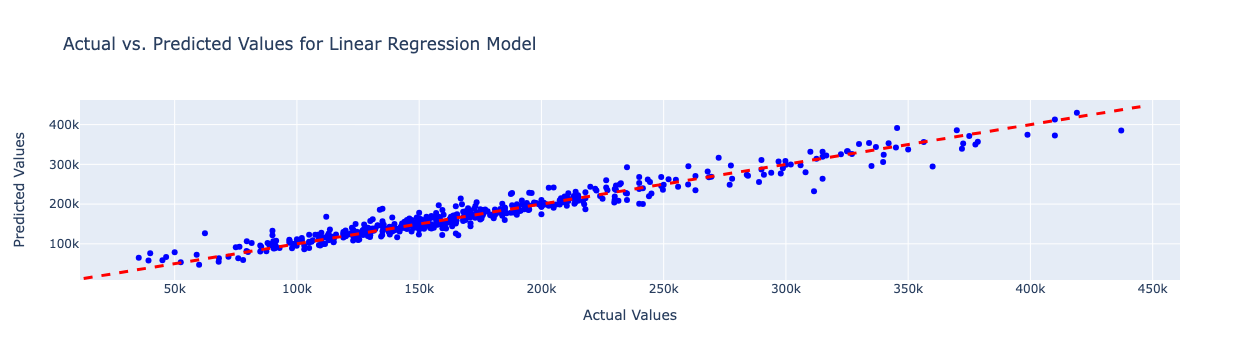

In [29]:
# Create a scatter plot with Plotly
fig = go.Figure()

# Add a scatter plot for actual vs. predicted values

fig.add_trace(go.Scatter(x=y_test, y=best_pred, mode='markers', marker=dict(color='blue'), 
                         name='Actual vs. Predicted'))

# Add a diagonal line for perfect predictions
fig.add_shape(type="line", x0=min(y), x1=max(y), y0=min(y), y1=max(y),
              line=dict(color="red", width=3, dash='dash'),
              name="Perfect Predictions")

# Update layout and axis labels
fig.update_layout(title="Actual vs. Predicted Values for Linear Regression Model",
                  xaxis_title="Actual Values",
                  yaxis_title="Predicted Values")

# Show the plot
fig.show()

In [30]:
import shap

# # Use the SHAP explainer
# explainer = shap.Explainer(best_model)

# # Calculate SHAP values for a subset of the data (e.g., test set)
# shap_values = explainer.shap_values(X_test)

# # Plot summary plot
# shap.summary_plot(shap_values, X_test)


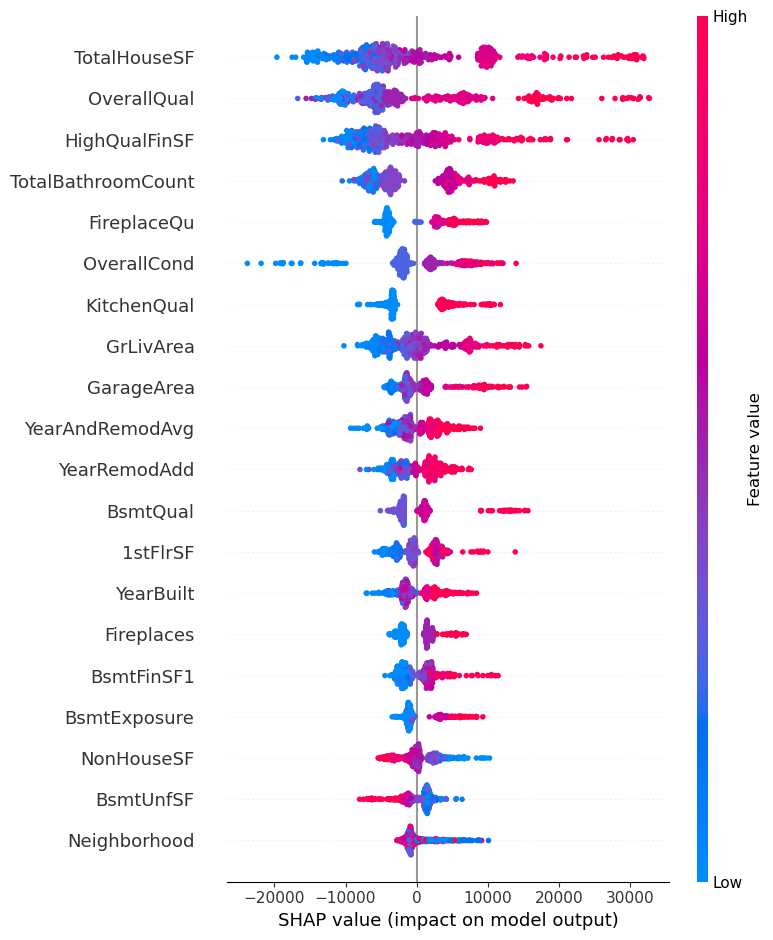

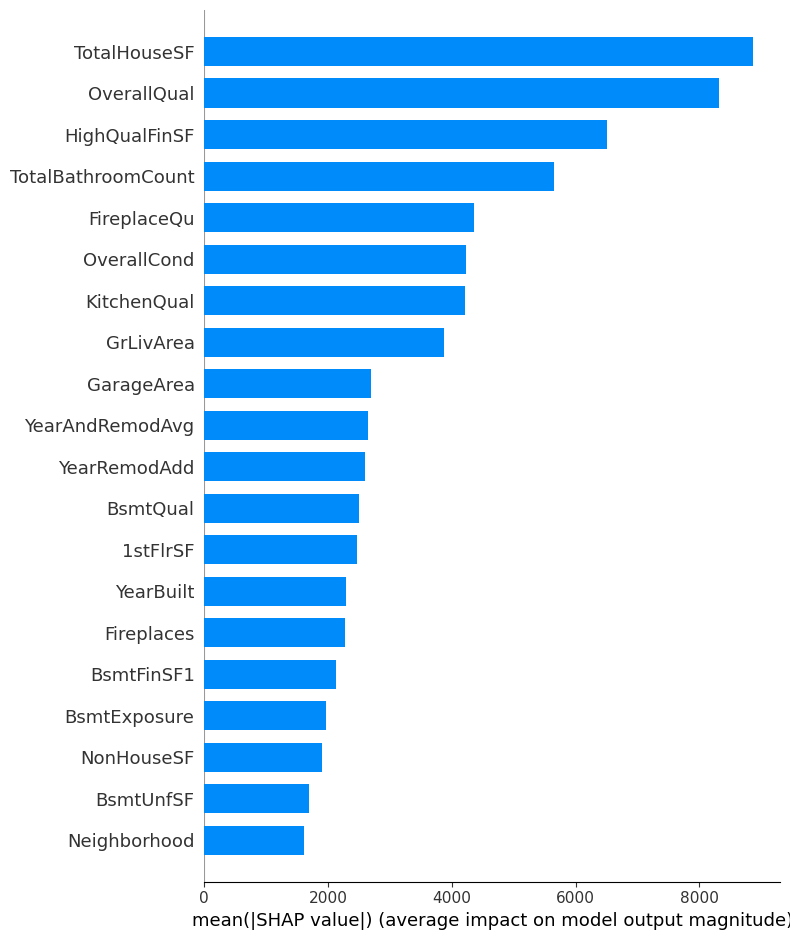

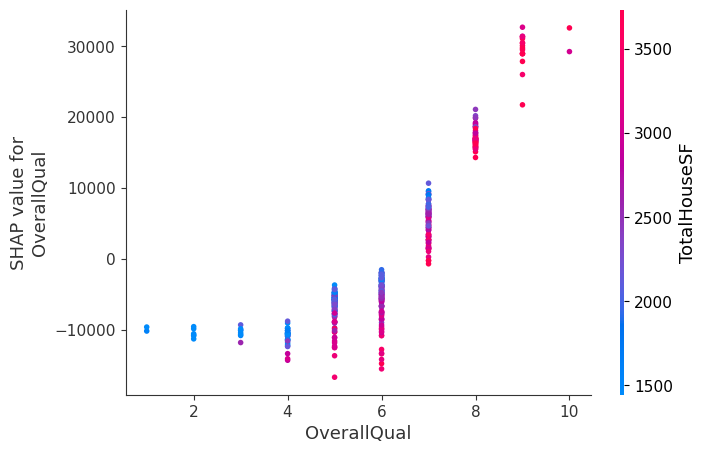

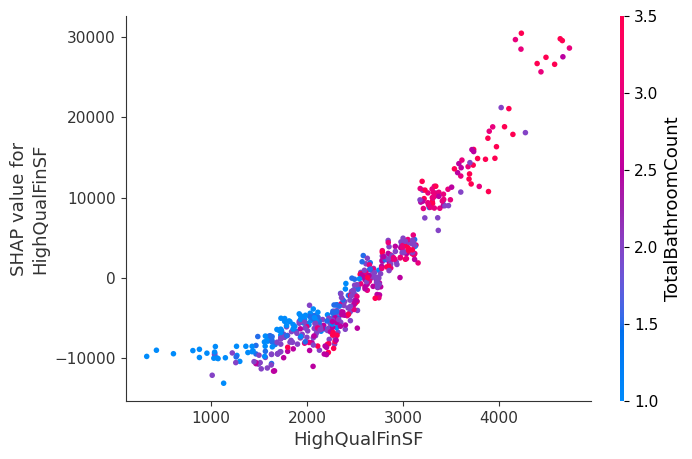

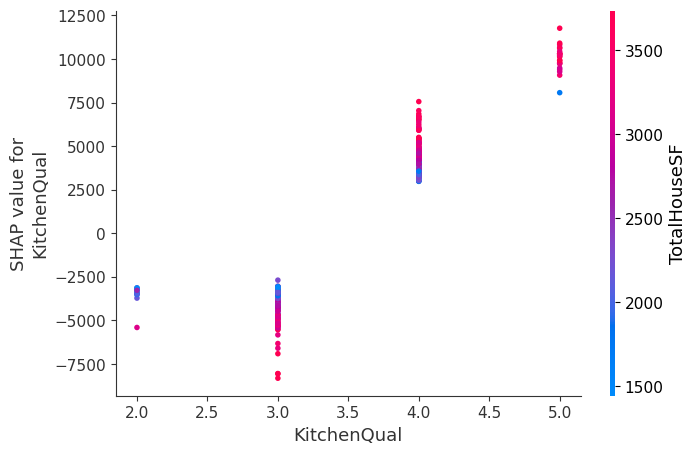

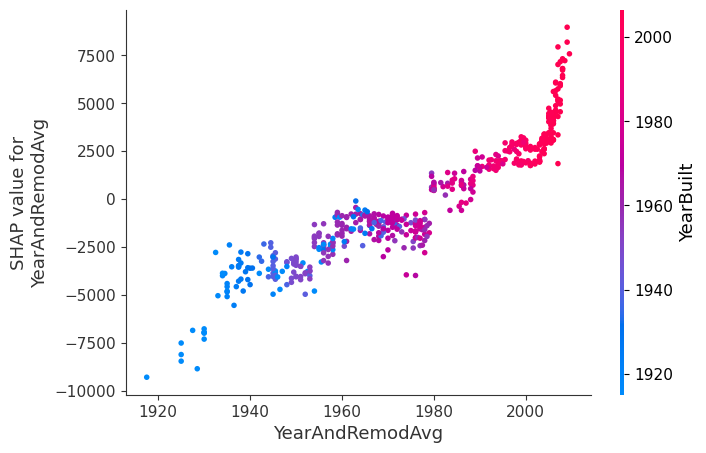

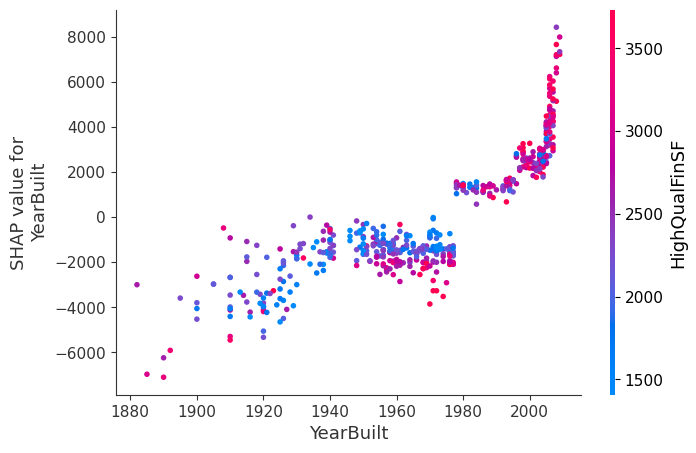

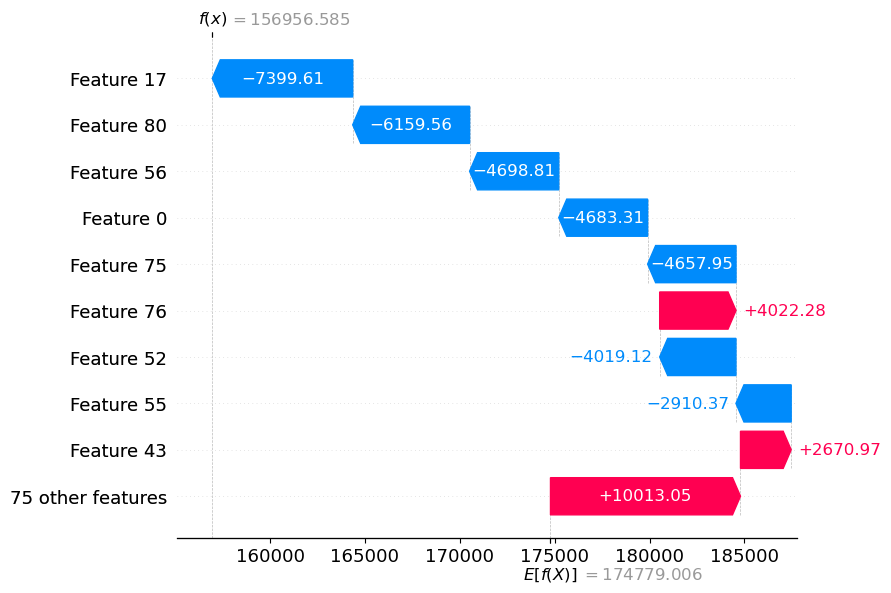

In [31]:
# Use the SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for a subset of the data (e.g., test set)
shap_values = explainer.shap_values(X_test)

# 1. Summary Plot
shap.summary_plot(shap_values, X_test)

# 2. Summary Bar Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 3. Dependence Plot
shap.dependence_plot("OverallQual", shap_values, X_test)
shap.dependence_plot("HighQualFinSF", shap_values, X_test)
shap.dependence_plot("KitchenQual", shap_values, X_test)
shap.dependence_plot("YearAndRemodAvg", shap_values, X_test)
shap.dependence_plot("YearBuilt", shap_values, X_test)


# 4. Force Plot (for a specific prediction)
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])

# 5. Waterfall Plot (for a specific prediction)
shap.waterfall_plot(shap.Explanation(values=shap_values[0, :], base_values=explainer.expected_value), max_display=10)


In [32]:
masterScores


Model  r2_5kf_mean  rmse_5kf_mean
0        catboost     0.919533   18889.778029
1  catboost_tuned     0.927884   17747.628941

In [33]:
output_file = 'masterScores_catboost.csv'

masterScores.to_csv(output_file, index=False, mode='w')

print(f"DataFrame exported to '{output_file}' in the same working directory.")

DataFrame exported to 'masterScores_catboost.csv' in the same working directory.


In [34]:
#the features will be X (independent variables)
model_name = 'catboost_tuned_gridsearchcv'

    #the features will be X (independent variables)
X = train_wOrdinal.drop('SalePrice', axis=1)
X_array = X.values
#the target (dependent variable) will be y
y = train_wOrdinal['SalePrice']
y_array = y.values

#Split your training and testing sets of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# given depth 6 iteration 100 and lr 0.1 r2 = .9186129
params = {
    # optuna params {'iterations': 434, 'learning_rate': 0.10599212903564667, 'depth': 5}
    'iterations': 100,
    'learning_rate': .10599212903564667,
    'depth': 6,
    'loss_function': 'RMSE',  # Use appropriate loss function for your task
    'random_seed': 42
                        }

# orig model params = 'iterations': 100,
#     'learning_rate': 0.1,
#     'depth': 6,
#     'loss_function': 'RMSE',  # Use appropriate loss function for your task
#     'random_seed': 42

cat_model = CatBoostRegressor(**params)

# Train the model on the training set
cat_model.fit(X_train, y_train)

# Make predictions on the test set
cat_model_y_pred = cat_model.predict(X_test)

# Evaluate the Random Forest model
cat_model_r2 = r2_score(y_test, cat_model_y_pred)
print(f'R-squared on the test set: {cat_model_r2}')

cat_model_mse = mean_squared_error(y_test, cat_model_y_pred)
print(f'Mean Squared Error on the test set: {cat_model_mse}')

# Root Mean Squared Error (RMSE) on the test set
cat_model_rmse = mean_squared_error(y_test, cat_model_y_pred, squared=False)
print("Root Mean Squared Error (RMSE) on the test set:", cat_model_rmse)

# Display feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': cat_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print('\nFeature Importances:')
print(feature_importances)



# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(cat_model, X, y, cv=kf, scoring='r2')
# You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

def rmse_scorer(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        return rmse
    
    
# Define the scoring function using neg_mean_squared_error
scorer = make_scorer(rmse_scorer)
# Use cross_val_score with the defined scorer
rmse_scores = cross_val_score(cat_model, X, y, cv=kf, scoring=scorer)



# Display the cross-validation scores
print("Cross-Validation Scores Rsquared:", cv_scores, '\n')
print("Cross-Validation Scores RMSE:", rmse_scores, '\n')

# Print the mean and standard deviation of the scores
print(f"Mean R^2: {cv_scores.mean()}", '\n')
print(f"Standard Deviation R^2: {cv_scores.std()}", '\n')
print(f"Mean RMSE: {rmse_scores.mean()}")

record = {'Model': model_name, 'r2_5kf_mean': cv_scores.mean(), 'rmse_5kf_mean': rmse_scores.mean()}
masterScores = masterScores.append(record, ignore_index=True)

0:	learn: 33376.5508207	total: 2.99ms	remaining: 296ms
1:	learn: 28743.7510501	total: 5.37ms	remaining: 263ms
2:	learn: 26175.4016870	total: 7.38ms	remaining: 239ms
3:	learn: 24739.7698483	total: 8.99ms	remaining: 216ms
4:	learn: 24013.0693267	total: 10.8ms	remaining: 205ms
5:	learn: 22594.7571187	total: 13.5ms	remaining: 212ms
6:	learn: 21278.4651831	total: 15.2ms	remaining: 202ms
7:	learn: 20180.8483706	total: 16.9ms	remaining: 194ms
8:	learn: 19503.2927251	total: 18.7ms	remaining: 189ms
9:	learn: 18807.1984797	total: 20.5ms	remaining: 184ms
10:	learn: 18172.2567773	total: 22.1ms	remaining: 179ms
11:	learn: 17518.8747547	total: 23.8ms	remaining: 174ms
12:	learn: 16750.2028163	total: 25.5ms	remaining: 170ms
13:	learn: 16214.4200799	total: 27.4ms	remaining: 168ms
14:	learn: 15796.3035365	total: 29.2ms	remaining: 165ms
15:	learn: 15196.2661818	total: 31ms	remaining: 163ms
16:	learn: 14818.8897286	total: 32.8ms	remaining: 160ms
17:	learn: 14522.0820790	total: 34.3ms	remaining: 156ms
18:	

In [41]:
masterScores

Model  r2_5kf_mean  rmse_5kf_mean
0                     catboost     0.919533   18889.778029
1               catboost_tuned     0.927884   17747.628941
2  catboost_tuned_gridsearchcv     0.870380   24023.203744

In [35]:
# # Define the CatBoostRegressor
# catboost_model = CatBoostRegressor()


# # optuna params {'iterations': 434, 'learning_rate': 0.10599212903564667, 'depth': 5}
# # Define the parameter grid for grid search
# # param_grid = {
# #     'iterations': [300, 400, 500],
# #     'depth': [6, 8, 10],
# #     'learning_rate': [0.1, 0.05, 0.01]
# # }

# param_grid = {
#     'iterations': [100, 200, 300],
#     'depth': [5, 6, 8],
#     'learning_rate': [0.1, 0.05, 0.11]
# }

# # Define custom scoring functions
# def custom_r2_score(model, X, y):
#     predictions = model.predict(X)
#     return r2_score(y, predictions)

# def custom_rmse_score(model, X, y):
#     predictions = model.predict(X)
#     return np.sqrt(mean_squared_error(y, predictions))

# # Create scorer objects
# r2_scorer = make_scorer(custom_r2_score, greater_is_better=True)
# rmse_scorer = make_scorer(custom_rmse_score, greater_is_better=False)

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(
#     catboost_model, param_grid, scoring={'r2': r2_scorer, 'rmse': rmse_scorer}, cv=5, refit='r2'
# )
# grid_search.fit(X_train, y_train)

# # Get the best parameters and best estimator
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# # Get cross-validated scores
# r2_cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring=r2_scorer)
# rmse_cv_scores = -cross_val_score(best_model, X_train, y_train, cv=5, scoring=rmse_scorer)

# # Print the results
# print("Best Parameters:", best_params)
# print("Cross-validated R-squared scores:", r2_cv_scores)
# print("Cross-validated RMSE scores:", rmse_cv_scores)

In [36]:
# best_params

In [37]:
# best_model

In [38]:
# r2_cv_scores = cross_val_score(best_model, X, y, cv=kf, scoring='r2')

In [39]:
# r2_cv_scores.mean()

In [40]:
# with param grid = 100, 200, 300; depth was 6, 8, 10, and rate at .1 .05 .01... given depth 6 iteration 100 and lr 0.1 r2 = .9186129
# {'depth': 5, 'iterations': 100, 'learning_rate': 0.1}
